<font size=5>互评作业2：频繁模式与关联规则挖掘</font>

**问题描述：**

    ·对数据集进行处理，转换成适合进行关联规则挖掘的形式；
    ·找出频繁模式；
    ·导出关联规则，计算其支持度和置信度;
    ·对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种；
    ·对挖掘结果进行分析；
    ·可视化展示

**1.数据处理：**

数据集选取 wine reviews

In [69]:
import  matplotlib.pyplot as plt
import numpy as np
import  pandas as pd
#导入数据
wine_1 = pd.read_csv("../homework1/winemag/winemag-data_first150k.csv")
wine_2 = pd.read_csv("../homework1/winemag/winemag-data-130k-v2.csv")
#合并数据集
wine = pd.concat([wine_1, wine_2], ignore_index=True)
wine=wine.drop(labels='Unnamed: 0', axis=1)
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280901 entries, 0 to 280900
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                280833 non-null  object 
 1   description            280901 non-null  object 
 2   designation            197701 non-null  object 
 3   points                 280901 non-null  int64  
 4   price                  258210 non-null  float64
 5   province               280833 non-null  object 
 6   region_1               234594 non-null  object 
 7   region_2               111464 non-null  object 
 8   variety                280900 non-null  object 
 9   winery                 280901 non-null  object 
 10  taster_name            103727 non-null  object 
 11  taster_twitter_handle  98758 non-null   object 
 12  title                  129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 27.9+ MB


对country进行挖掘，对于其缺失值通过属性的相关关系进行填补，使用designation属性判断所属国家

In [42]:
new_wine=wine.dropna(axis=0)
print(new_wine.isnull().sum(axis=0))
new_wine.info()

country                  0
description              0
designation              0
points                   0
price                    0
province                 0
region_1                 0
region_2                 0
variety                  0
winery                   0
taster_name              0
taster_twitter_handle    0
title                    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22387 entries, 150934 to 280880
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                22387 non-null  object 
 1   description            22387 non-null  object 
 2   designation            22387 non-null  object 
 3   points                 22387 non-null  int64  
 4   price                  22387 non-null  float64
 5   province               22387 non-null  object 
 6   region_1               22387 non-null  object 
 7   region_2               22387 non-null  object 
 

price、points是数值属性，对price进行离散化处理

In [43]:
#加上前缀
def points_discretization(value):
    return "points-"+str(int(value/5))

def price_discretization(value):
    if value < 100 :
        return "price-"+str(int(value/10))
    else:
        return "price-10"

variety、winery、designation三个标称属性聚类数目过多（分别达到了632、14810、30622项），出于计算复杂度的考虑，在初步分析之后，单独选取选取variety中出现频数大于4000和winery中出现频数大于200的非空聚类进行分析。 初步分析过程中选取的属性包括province、price、points,region_1,region_2,variety,winery，在之后的找出频繁模式调用mlxtend库来实现，因此还需要将数据处理成相应的格式。

In [44]:
#处理空值
#过滤属性
new_wine = new_wine.drop(['country','description','designation','title','taster_name','taster_twitter_handle'],axis=1)
new_wine

,points,price,province,region_1,region_2,variety,winery
150934,87,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Sweet Cheeks
150940,87,19.0,California,Napa Valley,Napa,Cabernet Sauvignon,Kirkland Signature
150953,87,22.0,California,Paso Robles,Central Coast,Merlot,Bianchi
150955,87,69.0,California,Sonoma Coast,Sonoma,Pinot Noir,Castello di Amorosa
150965,86,50.0,Oregon,McMinnville,Willamette Valley,Pinot Noir,Erath
...,...,...,...,...,...,...,...
280849,91,105.0,Washington,Walla Walla Valley (WA),Columbia Valley,Red Blend,Nicholas Cole Cellars
280856,91,41.0,Washington,Walla Walla Valley (WA),Columbia Valley,Syrah,Reininger
280875,90,20.0,California,Santa Ynez Valley,Central Coast,Chenin Blanc,Birichino
280879,90,35.0,California,Napa Valley,Napa,Chardonnay,Flora Springs


In [46]:
#离散化处理
new_wine.loc[:,'points'] = new_wine['points'].map(lambda x:points_discretization(x))
new_wine.loc[:,'price'] = new_wine['price'].map(lambda x:price_discretization(x))
new_wine

,points,price,province,region_1,region_2,variety,winery
150934,points-17,price-6,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Sweet Cheeks
150940,points-17,price-1,California,Napa Valley,Napa,Cabernet Sauvignon,Kirkland Signature
150953,points-17,price-2,California,Paso Robles,Central Coast,Merlot,Bianchi
150955,points-17,price-6,California,Sonoma Coast,Sonoma,Pinot Noir,Castello di Amorosa
150965,points-17,price-5,Oregon,McMinnville,Willamette Valley,Pinot Noir,Erath
...,...,...,...,...,...,...,...
280849,points-18,price-10,Washington,Walla Walla Valley (WA),Columbia Valley,Red Blend,Nicholas Cole Cellars
280856,points-18,price-4,Washington,Walla Walla Valley (WA),Columbia Valley,Syrah,Reininger
280875,points-18,price-2,California,Santa Ynez Valley,Central Coast,Chenin Blanc,Birichino
280879,points-18,price-3,California,Napa Valley,Napa,Chardonnay,Flora Springs


In [47]:
#dataframe 转换为列表
def deal(data):
    return data.to_list()
new_wine_arr = new_wine.apply(deal,axis=1).tolist()
new_wine_arr

[['points-17',
  'price-6',
  'Oregon',
  'Willamette Valley',
  'Willamette Valley',
  'Pinot Noir',
  'Sweet Cheeks'],
 ['points-17',
  'price-1',
  'California',
  'Napa Valley',
  'Napa',
  'Cabernet Sauvignon',
  'Kirkland Signature'],
 ['points-17',
  'price-2',
  'California',
  'Paso Robles',
  'Central Coast',
  'Merlot',
  'Bianchi'],
 ['points-17',
  'price-6',
  'California',
  'Sonoma Coast',
  'Sonoma',
  'Pinot Noir',
  'Castello di Amorosa'],
 ['points-17',
  'price-5',
  'Oregon',
  'McMinnville',
  'Willamette Valley',
  'Pinot Noir',
  'Erath'],
 ['points-17',
  'price-10',
  'California',
  'Napa Valley',
  'Napa',
  'Cabernet Sauvignon',
  'Okapi'],
 ['points-17',
  'price-2',
  'Washington',
  'Columbia Valley (WA)',
  'Columbia Valley',
  'Cabernet Franc',
  'Ram'],
 ['points-17',
  'price-2',
  'California',
  'Santa Ynez Valley',
  'Central Coast',
  'Sauvignon Blanc',
  'Sevtap'],
 ['points-17',
  'price-4',
  'Washington',
  'Columbia Valley (WA)',
  'Columbi

In [48]:
#TransationEncoder转换
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
tf = te.fit_transform(new_wine_arr)
new_df = pd.DataFrame(tf,columns=te.columns_)

**2.频繁模式**

支持度阈值设置为0.03

In [49]:
from mlxtend.frequent_patterns import apriori
result = apriori(new_df, min_support=0.03, use_colnames=True,max_len=4).sort_values(by='support',ascending=False)
print(result.shape)

(207, 2)


In [58]:
result

,support,itemsets
2,0.576227,(California)
24,0.516728,(points-18)
23,0.420065,(points-17)
53,0.324072,"(California, points-18)"
18,0.261089,(Washington)
...,...,...
32,0.030643,"(Bordeaux-style Red Blend, Columbia Valley)"
144,0.030643,"(California, Napa Valley, points-18)"
87,0.030643,"(Napa Valley, points-18)"
103,0.030598,"(Red Blend, points-18)"


**3.关联规则**

在频繁项集中导出关联规则，计算支持度和置信度，支持度阈值为0.03，置信度阈值为0.4

In [57]:
from mlxtend.frequent_patterns import association_rules
rules = association_rules(result,metric= 'confidence', min_threshold=0.4)
rules = rules.drop(['leverage','conviction'],axis = 1)
print(rules.shape)
rules

(331, 7)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,(California),(points-18),0.576227,0.516728,0.324072,0.562403,1.088392
1,(points-18),(California),0.516728,0.576227,0.324072,0.627161,1.088392
2,(Washington),(Columbia Valley),0.261089,0.247108,0.247108,0.946450,3.830111
3,(Columbia Valley),(Washington),0.247108,0.261089,0.247108,1.000000,3.830111
4,(points-17),(California),0.420065,0.576227,0.216688,0.515844,0.895210
...,...,...,...,...,...,...,...
326,"(California, Napa Valley)",(points-18),0.051458,0.516728,0.030643,0.595486,1.152416
327,"(Napa Valley, points-18)",(California),0.030643,0.576227,0.030643,1.000000,1.735426
328,(Napa Valley),"(California, points-18)",0.051458,0.324072,0.030643,0.595486,1.837512
329,(Napa Valley),(points-18),0.051458,0.516728,0.030643,0.595486,1.152416


导出关联规则

In [59]:
for index,row in rules.iterrows():
    t1 = tuple(row['antecedents'])
    t2 = tuple(row['consequents'])
    print("%s => %s(support = %f, confidence = %f)"%(t1,t2,row['support'],row['confidence']))



('California',) => ('points-18',)(support = 0.324072, confidence = 0.562403)
('points-18',) => ('California',)(support = 0.324072, confidence = 0.627161)
('Washington',) => ('Columbia Valley',)(support = 0.247108, confidence = 0.946450)
('Columbia Valley',) => ('Washington',)(support = 0.247108, confidence = 1.000000)
('points-17',) => ('California',)(support = 0.216688, confidence = 0.515844)
('Central Coast',) => ('California',)(support = 0.209452, confidence = 1.000000)
('Sonoma',) => ('California',)(support = 0.149864, confidence = 1.000000)
('Pinot Noir',) => ('points-18',)(support = 0.134587, confidence = 0.629282)
('price-2',) => ('points-17',)(support = 0.133828, confidence = 0.589880)
('California', 'points-18') => ('Central Coast',)(support = 0.129897, confidence = 0.400827)
('California', 'Central Coast') => ('points-18',)(support = 0.129897, confidence = 0.620175)
('points-18', 'Central Coast') => ('California',)(support = 0.129897, confidence = 1.000000)
('Central Coast',)

**4.规则评价**

对规则进行评价，使用提升度lift和全置信度allconf。提升度在导出关联规则时已经被计算出了


In [60]:
def allconf(x):
    return x.support/max(x['antecedent support'],x['consequent support'])
allconf_list = []
for index, row in rules.iterrows():
    allconf_list.append(allconf(row))
rules['allconf'] = allconf_list
rules.drop(['antecedent support','consequent support'],axis=1,inplace=False)


,antecedents,consequents,support,confidence,lift,allconf
0,(California),(points-18),0.324072,0.562403,1.088392,0.562403
1,(points-18),(California),0.324072,0.627161,1.088392,0.562403
2,(Washington),(Columbia Valley),0.247108,0.946450,3.830111,0.946450
3,(Columbia Valley),(Washington),0.247108,1.000000,3.830111,0.946450
4,(points-17),(California),0.216688,0.515844,0.895210,0.376047
...,...,...,...,...,...,...
326,"(California, Napa Valley)",(points-18),0.030643,0.595486,1.152416,0.059302
327,"(Napa Valley, points-18)",(California),0.030643,1.000000,1.735426,0.053178
328,(Napa Valley),"(California, points-18)",0.030643,0.595486,1.837512,0.094555
329,(Napa Valley),(points-18),0.030643,0.595486,1.152416,0.059302


In [66]:
#过滤allconf小于0.2的规则，按lift从小到大排序
final_rules = rules.iloc[:]
from sklearn.preprocessing import LabelEncoder
for index, row in final_rules.iterrows():
    if row['allconf'] < 0.2:
        final_rules.drop(index = index, inplace = True)
final_rules = final_rules.sort_values(by=['lift'],ascending=False)
final_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,allconf
124,"(Napa, California)",(Napa Valley),0.086211,0.051458,0.051458,0.596891,11.599482,0.596891
323,"(points-18, Napa Valley)","(Napa, California)",0.030643,0.086211,0.030643,1.000000,11.599482,0.355440
131,(Napa Valley),(Napa),0.051458,0.086211,0.051458,1.000000,11.599482,0.596891
130,(Napa),(Napa Valley),0.086211,0.051458,0.051458,0.596891,11.599482,0.596891
319,"(California, points-18, Napa Valley)",(Napa),0.030643,0.086211,0.030643,1.000000,11.599482,0.355440
...,...,...,...,...,...,...,...,...
22,(price-2),(California),0.226873,0.576227,0.118685,0.523134,0.907861,0.205969
4,(points-17),(California),0.420065,0.576227,0.216688,0.515844,0.895210,0.376047
26,(Columbia Valley),(points-18),0.247108,0.516728,0.111851,0.452639,0.875971,0.216459
27,"(Washington, Columbia Valley)",(points-18),0.247108,0.516728,0.111851,0.452639,0.875971,0.216459


In [67]:
for index,row in final_rules.iterrows():
    t1 = tuple(row['antecedents'])
    t2 = tuple(row['consequents'])
    print("%s => %s(support = %f, confidence = %f)"%(t1,t2,row['support'],row['confidence']))



('Napa', 'California') => ('Napa Valley',)(support = 0.051458, confidence = 0.596891)
('points-18', 'Napa Valley') => ('Napa', 'California')(support = 0.030643, confidence = 1.000000)
('Napa Valley',) => ('Napa',)(support = 0.051458, confidence = 1.000000)
('Napa',) => ('Napa Valley',)(support = 0.051458, confidence = 0.596891)
('California', 'points-18', 'Napa Valley') => ('Napa',)(support = 0.030643, confidence = 1.000000)
('Napa Valley',) => ('Napa', 'California')(support = 0.051458, confidence = 1.000000)
('Napa',) => ('California', 'Napa Valley')(support = 0.051458, confidence = 0.596891)
('Napa Valley', 'points-18') => ('Napa',)(support = 0.030643, confidence = 1.000000)
('California', 'Napa Valley') => ('Napa',)(support = 0.051458, confidence = 1.000000)
('Napa Valley',) => ('Napa', 'California', 'points-18')(support = 0.030643, confidence = 0.595486)
('Napa', 'points-18') => ('Napa Valley',)(support = 0.030643, confidence = 0.580372)
('Napa Valley',) => ('Napa', 'points-18')(su

**5.可视化展示**



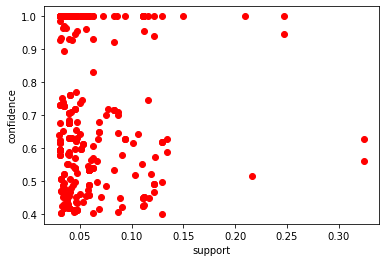

In [70]:
#生成rules规则
plt.xlabel('support')
plt.ylabel('confidence')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.confidence[i],c='r')

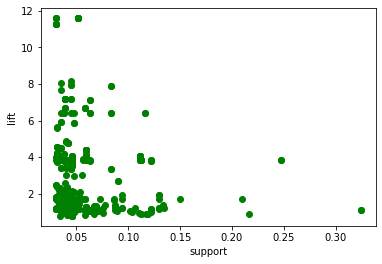

In [71]:
plt.xlabel('support')
plt.ylabel('lift')
for i in range(len(rules)):
    plt.scatter(rules.support[i],rules.lift[i],c='g')